In [27]:
import numpy as np
from qiskit.circuit.gate import Gate
from qiskit.circuit.parameterexpression import ParameterValueType

class RiSwapGate(Gate):
    r"""RiSWAP gate.

    **Circuit Symbol:**

    .. parsed-literal::

        q_0: ─⨂─
           R(alpha)
        q_1: ─⨂─

    """

    def __init__(self, alpha: ParameterValueType):
        """Create new iSwap gate."""
        super().__init__(
            "riswap", 2, [alpha], label=r"$\sqrt[" + str(int(1 / alpha)) + r"]{iSwap}$"
        )

    def __array__(self, dtype=None):
        """Return a numpy.array for the RiSWAP gate."""
        alpha = self.params[0]
        return np.array(
            [
                [1, 0, 0, 0],
                [0, np.cos(np.pi * alpha / 2), 1j * np.sin(np.pi * alpha / 2), 0],
                [0, 1j * np.sin(np.pi * alpha / 2), np.cos(np.pi * alpha / 2), 0],
                [0, 0, 0, 1],
            ],
            dtype=dtype,
        )
    
    def inverse(self):
        """Return inverse gate."""
        from qiskit.extensions import UnitaryGate
        return UnitaryGate(data=np.matrix(self.__array__()).getH())

    @staticmethod
    def latex_string(gate_params=None):
        if gate_params is None:
            return r"$\sqrt[n]{iSwap}$"
        else:
            n = 1 / gate_params[0]
            return r"$\sqrt[" + str(int(n)) + r"]{iSwap}$"


In [28]:
from qiskit.circuit.library import RZXGate
import numpy as np

# gates = [RZXGate(np.pi/3), RZXGate(np.pi/3), RZXGate(np.pi/3), RZXGate(np.pi/3)]
gates = [RiSwapGate(1/4), RiSwapGate(1/4).inverse()]# RiSwapGate(1/3), RiSwapGate(1/4)]

from fractions import Fraction
from monodromy.coordinates import monodromy_to_positive_canonical_polytope, \
    positive_canonical_alcove_c2, unitary_to_monodromy_coordinate
from monodromy.coverage import deduce_qlr_consequences
from monodromy.static.examples import exactly, identity_polytope, \
    everything_polytope


circuit_polytope = identity_polytope


for gate in gates:
    b_polytope = exactly(
        *(Fraction(x).limit_denominator(10_000)
          for x in unitary_to_monodromy_coordinate(gate.to_matrix())[:-1])
    )
    circuit_polytope = deduce_qlr_consequences(
        target="c",
        a_polytope=circuit_polytope,
        b_polytope=b_polytope,
        c_polytope=everything_polytope
    )

print(monodromy_to_positive_canonical_polytope(circuit_polytope))
print(f"{monodromy_to_positive_canonical_polytope(circuit_polytope).volume} vs "
      f"{positive_canonical_alcove_c2.volume}")

[
# anonymous_convex_polytope_51: 
    0 +     1 x1 +    -1 x2 +    -1 x3 >= 0
    2 +    -8 x1 +     0 x2 +     0 x3 >= 0
    0 +     0 x1 +     2 x2 +    -2 x3 >= 0
    0 +     0 x1 +     0 x2 +     2 x3 >= 0
,
# anonymous_convex_polytope_52: 
    2 +    -2 x1 +    -2 x2 +    -2 x3 >= 0
    0 +     0 x1 +     2 x2 +    -2 x3 >= 0
   -6 +     8 x1 +     0 x2 +     0 x3 >= 0
    0 +     0 x1 +     0 x2 +     2 x3 >= 0

]
PolytopeVolume(dimension=3, volume=Fraction(1, 384)) vs PolytopeVolume(dimension=3, volume=Fraction(1, 24))


In [29]:
polytope_vertices = monodromy_to_positive_canonical_polytope(circuit_polytope).vertices
reduced_vertices = monodromy_to_positive_canonical_polytope(circuit_polytope.reduce()).vertices

In [30]:
%matplotlib widget

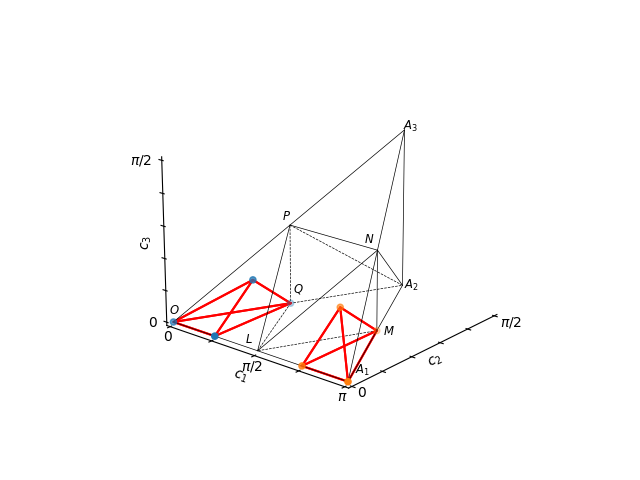

In [32]:
from weylchamber import WeylChamber
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
w = WeylChamber();
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
total_coord_list = []
for subpoly in reduced_vertices:
    subpoly_coords = [[float(x) for x in coord] for coord in subpoly]
    total_coord_list += subpoly_coords
    w.scatter(*zip(*subpoly_coords))

    pts = np.array(subpoly_coords)
    hull = ConvexHull(pts)
    for s in hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

w.render(ax)